In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uplift-hw-03/criteo-uplift-v2.1.csv


In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scikit-uplift

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 708.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install causalml 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 31.6 MB/s eta 0:00:00
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24552 sha256=2aae80571ebaa91393455f4de200e046482d5c97ed498352ce4046c47ae2263b
  Stored in directory: /root/.cache/pip/wheels/69/b2/67/08f0eef649af92df772c09f451558298e07fab1bc7cdf33db0
Successfully built pydotplus
  Attempting uninstall: Cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8
  Attempting uninstall: pathos
    F

In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Импортируем S- и T-learner`ы (BaseSClassifier и BaseTClassifier) из библиотеки CausalML
from causalml.inference.meta import BaseSClassifier, BaseTClassifier
from causalml.inference.meta import BaseXClassifier, BaseRClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

# В качестве классификатора воспользуемся моделью градиентного бустинга от Яндекса (CatBoost)
from catboost import CatBoostClassifier
%matplotlib inline

from sklearn.model_selection import train_test_split

# Uplift-дерево и слу8чайный лес
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

In [6]:
import pandas as pd
df = pd.read_csv("/kaggle/input/uplift-hw-03/criteo-uplift-v2.1.csv")
    

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


In [8]:
df.shape

(13979592, 16)

In [9]:
df['target_class'] = 0

mask_1 = (df['conversion'] == 1) & (df['treatment'] == 0)
df.loc[mask_1, 'target_class'] = 1

mask_2 = (df['conversion'] == 0) & (df['treatment'] == 1)
df.loc[mask_2, 'target_class'] = 2

mask_3 = (df['conversion'] == 1) & (df['treatment'] == 1)
df.loc[mask_3, 'target_class'] = 3

df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure,target_class
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0,2
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0,2
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0,2
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0,2
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0,2


In [10]:
df

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure,target_class
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0,2
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0,2
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0,2
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0,2
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979587,26.297764,10.059654,9.006250,4.679882,10.280525,4.115453,-3.282109,4.833815,3.839578,13.190056,5.300375,-0.168679,1,0,0,0,2
13979588,12.642207,10.679513,8.214383,-1.700105,10.280525,3.013064,-13.955150,6.269026,3.971858,13.190056,5.300375,-0.168679,1,0,0,1,2
13979589,12.976557,10.059654,8.381868,0.842442,11.029584,4.115453,-8.281971,4.833815,3.779212,23.570168,6.169187,-0.168679,1,0,1,0,2
13979590,24.805064,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,2


##  разделим данные на тренировочную и тестовую выборку

In [11]:
feature_cols = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10','f11', ]
target_col = 'conversion'
treatment_col = 'treatment'

In [12]:
# Разделим данные на тренировочную и тестовую выборки.
df_train, df_test = train_test_split(
    df, 
    stratify=df[[treatment_col, target_col]], 
    random_state=42, 
    test_size=0.2
)
print('Размер тренировочной выборки:', df_train.shape[0])
print('Размер тестовой выборки:', df_test.shape[0])

Размер тренировочной выборки: 11183673
Размер тестовой выборки: 2795919


In [13]:
def random_under(df:pd.DataFrame):   
        
    df_0 = df[df['treatment'] == 0]
    df_1 = df[df['treatment'] == 1]

    df_treatment_under = df_1.sample(len(df_0))
    
    df_1 = pd.concat([df_treatment_under, df_0], axis=0)
    
    return df_1

In [14]:
df_train = random_under(df_train)
df_train.shape

(3355098, 17)

In [15]:
from sklift.models import SoloModel, TwoModels

In [16]:
# Воспользуемся функцией для оценки qini-curve из обучающего модуля
def qini_df(df, title='train', figsize=(5, 3)):
    # Отранжируем выборку по значению uplift в убывающем порядке
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # Посчитаем в отсортированном датафрейме основные показатели, которые используются при расчете qini
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # Посчитаем qini curve и рандомную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # Добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    
    # Немного кода для визуализации
    fig = plt.figure(figsize=figsize)
    plt.plot(ranked['n'], ranked['uplift'], color='r', label='Model')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b', label='RandomModel')
    plt.legend()
    plt.title('Qini-curve for {} samples'.format(title))
    plt.show()
    quni_score = (ranked['uplift'] - ranked['random_uplift']).sum()
    print('Qini score: {:.3f}'.format(quni_score))

# S-learner

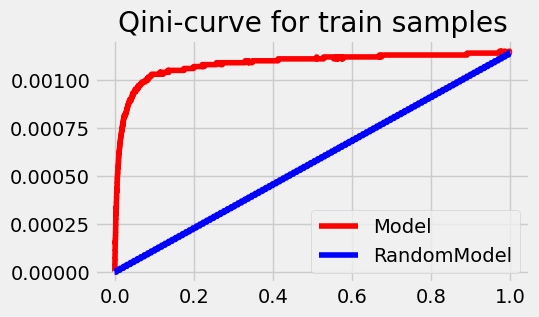

Qini score: 1723.658


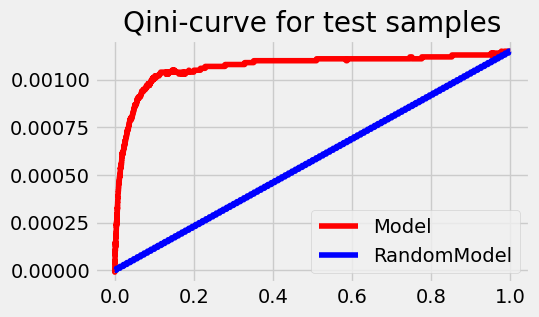

Qini score: 1373.702


In [17]:
# Создаем базовый S-learner
s_learner = SoloModel(
    estimator=LogisticRegression(random_state=42)
)

# Обучим модель
s_learner = s_learner.fit(
    X=df_train[feature_cols],
    y=df_train[target_col],
    treatment=df_train[treatment_col]
)

# Предсказание uplift-эффекта на обучающей выборке
uplift_vals = s_learner.predict(df_train[feature_cols])
df_train['uplift_score'] = uplift_vals

# Предсказание uplift-эффекта на тестовой выборке
uplift_vals = s_learner.predict(df_test[feature_cols])
df_test['uplift_score'] = uplift_vals

# Рассчитаем qini score
qini_df(df_train, title='train')
qini_df(df_test, title='test')

# T-learner

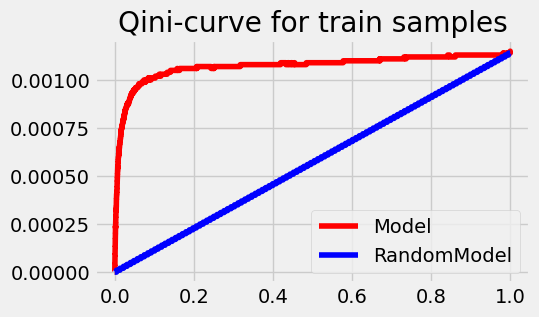

Qini score: 1681.253


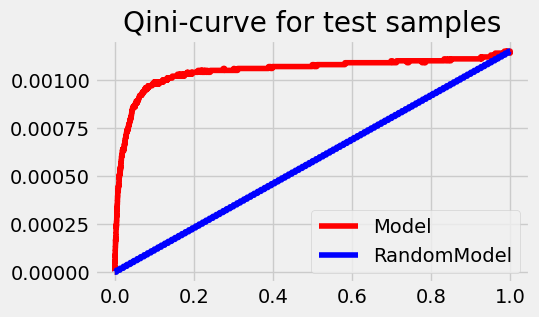

Qini score: 1320.379


In [18]:
# Создадим базовый T-learner
t_learner = TwoModels(
    estimator_trmnt=LogisticRegression(random_state=42),
    estimator_ctrl=LogisticRegression(random_state=42)
)

# Обучим модель
t_learner = t_learner.fit(
    X=df_train[feature_cols],
    y=df_train[target_col],
    treatment=df_train[treatment_col]
)

# Предсказание uplift-эффекта на обучающей выборке
uplift_vals = t_learner.predict(df_train[feature_cols])
df_train['uplift_score'] = uplift_vals

# Предсказание uplift-эффекта на тестовой выборке
uplift_vals = t_learner.predict(df_test[feature_cols])
df_test['uplift_score'] = uplift_vals

# Рассчитаем qini score
qini_df(df_train, title='train')
qini_df(df_test, title='test')

# X-learner

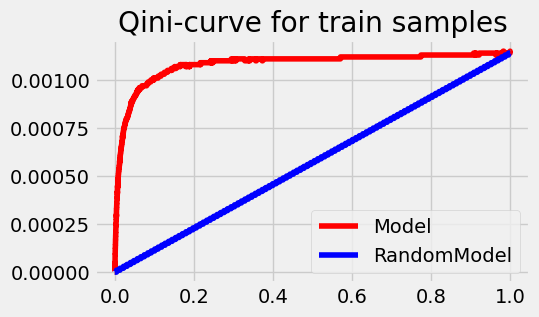

Qini score: 1716.696


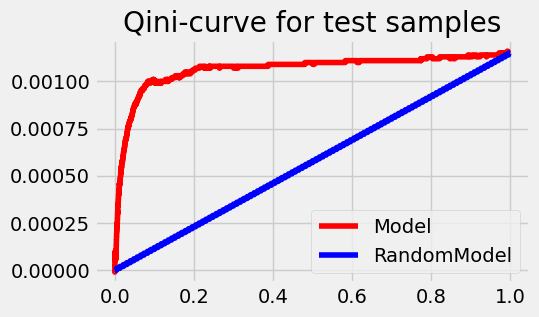

Qini score: 1367.138


In [19]:
# Создадим базовый X-learner
x_learner = BaseXClassifier(
    outcome_learner=LogisticRegression(random_state=42),
    effect_learner=LinearRegression()
)

# Обучим модель
x_learner.fit(
    X=df_train[feature_cols],
    treatment=df_train[treatment_col],
    y=df_train[target_col]
)

# Предсказание uplift-эффекта на обучающей выборке
uplift_vals = x_learner.predict(np.array(df_train[feature_cols].values.copy()))
df_train['uplift_score'] = uplift_vals

# Предсказание uplift-эффекта на тестовой выборке
uplift_vals = x_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

# Рассчитаем qini score
qini_df(df_train, title='train')
qini_df(df_test, title='test')

# R-learner

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

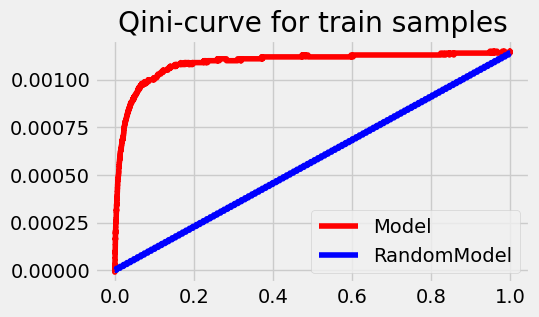

Qini score: 1739.378


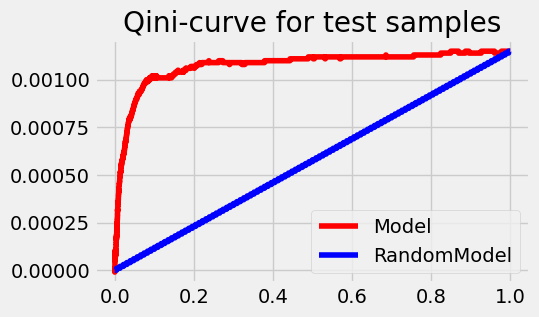

Qini score: 1397.898


In [20]:
# Создадим базовый R-learner
r_learner = BaseRClassifier(
    outcome_learner=LogisticRegression(random_state=42),
    effect_learner=LinearRegression(),
    random_state=42
)

# Обучим модель
r_learner.fit(
    X=df_train[feature_cols],
    treatment=df_train[treatment_col],
    y=df_train[target_col]
)

# Предсказание uplift-эффекта на обучающей выборке
uplift_vals = r_learner.predict(np.array(df_train[feature_cols].values.copy()))
df_train['uplift_score'] = uplift_vals

# Предсказание uplift-эффекта на тестовой выборке
uplift_vals = r_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

# Рассчитаем qini score
qini_df(df_train, title='train')
qini_df(df_test, title='test')

In [21]:
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

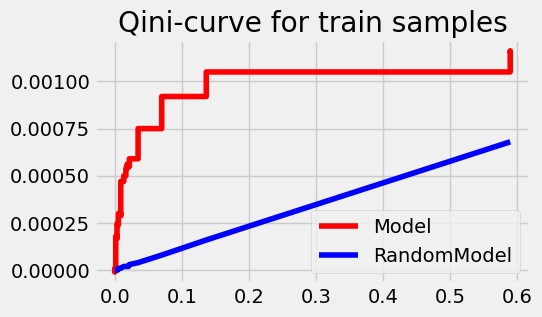

Qini score: 1335.120


In [22]:
uplift_model = UpliftTreeClassifier(max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='ED', control_name='0')

uplift_model.fit(df_train[feature_cols].values,
                 treatment=df_train[treatment_col].apply(str).values,
                 y=df_train[target_col].values)


uplift_vals = uplift_model.predict(np.array(df_test[feature_cols].values.copy()))
list_ = [x[0] for x in uplift_vals]

test_tmp = df_test.copy()
test_tmp['uplift_score'] = list_
qini_df(test_tmp)

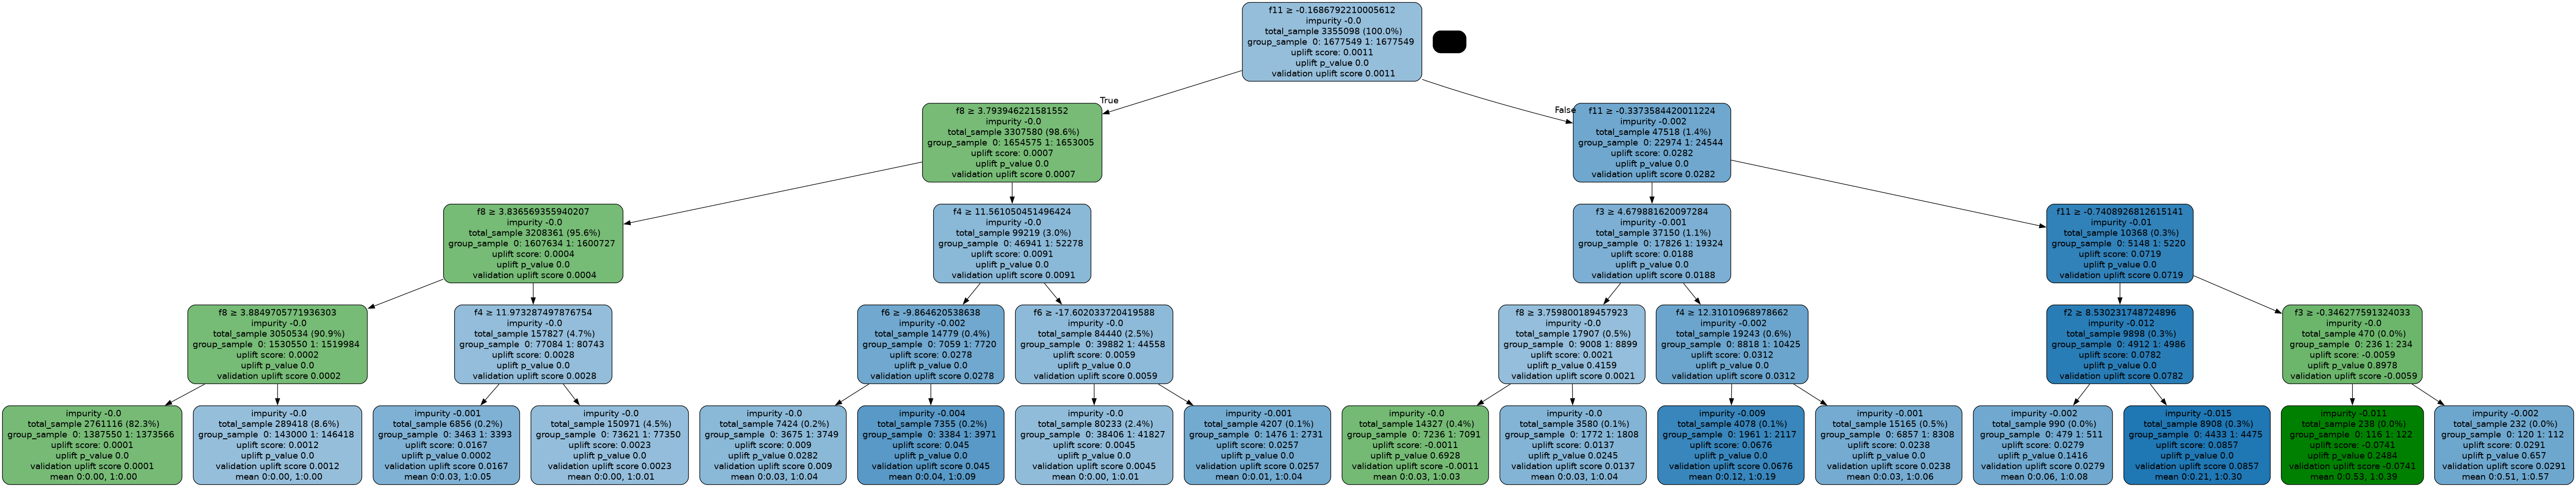

In [23]:
from IPython.display import Image
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, feature_cols)
Image(graph.create_png())

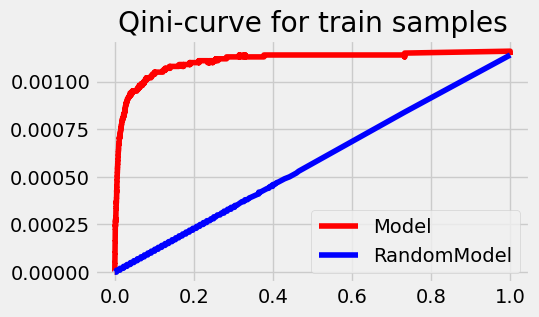

Qini score: 1793.039


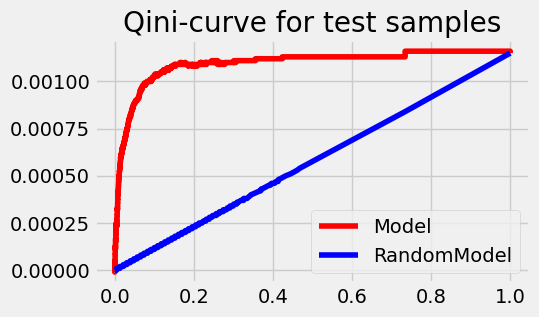

Qini score: 1462.202


In [24]:
# Создаем случайный лес.
uplift_forest = UpliftRandomForestClassifier(
    n_estimators=100, 
    max_depth=5, 
    min_samples_leaf=100, 
    min_samples_treatment=50,
    n_reg=100, 
    evaluationFunction='ED', 
    control_name='0', 
    random_state=42
)

# Обучим модель
uplift_forest.fit(
    df_train[feature_cols].values,
    treatment=df_train[treatment_col].apply(str).values,
    y=df_train[target_col].values
)

# Предсказание uplift-эффекта на обучающей выборке
uplift_vals = uplift_forest.predict(np.array(df_train[feature_cols].values.copy()))
df_train['uplift_score'] = uplift_vals

# Предсказание uplift-эффекта на тестовой выборке
uplift_vals = uplift_forest.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

# Рассчитаем qini score
qini_df(df_train, title='train')
qini_df(df_test, title='test')

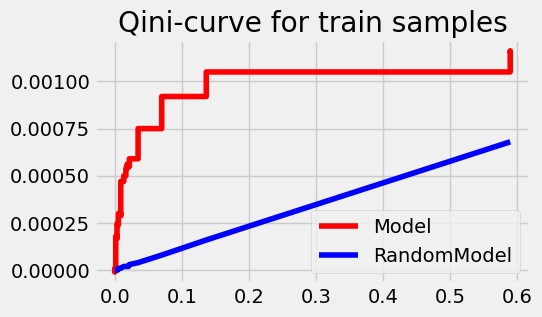

Qini score: 1335.120


In [25]:
test_tmp = df_test.copy()
test_tmp['uplift_score'] = list_
qini_df(test_tmp)

### по оценке на основе qini_qurve
### базовый S-learner,X-learner показали плохие результаты T-learner,R-learner, - хорошие